# Xarray-spatial
### User Guide: Zonal crosstab
-----

Xarray-spatial's zonal crosstab function provides an easy way to calculate cross-tabulated (categorical stats) areas between two datasets that can help in identifying patterns and trends in the data. In this notebook, we'll analyze temperature by elevation. We use temperature data from [MODIS](https://planetarycomputer.microsoft.com/dataset/modis-21A2-061) dataset. The elevation data is from [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem) dataset. Both the 2 are coutinuous data. To categorize them, we'll group elevation into different classes so that elevation of similar height will be in the same class. Similarly, temperature will also be classified into different classes. We'll use zonal crosstab in 2 different scenarios:


[2D Zonal Crosstab](#2D-Zonal-Crosstab) to see how temperature is changed by elevation.  
[3D Zonal Crosstab](#3D-Zonal-Crosstab) to see how temperature is changed by elevation over time.

-----------


## Load data

The region of interest is a small area around the [Death Valley National Park
](https://www.google.com/maps/place/Death+Valley+National+Park/@36.5052209,-119.093306,538106m/data=!3m1!1e3!4m5!3m4!1s0x80c74b7776ae8a47:0xccc9f07c7bf2b054!8m2!3d36.5053891!4d-117.0794078!5m1!1e4), Skidoo, California, USA with an extent of `[-118, 36, -117, 37]` (EPSG:4326).

All data in this notebook has been loaded from stac items and has been coregistered so that they are well aligned. 

In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

from datashader.transfer_functions import shade, stack, Images

from xrspatial import hillshade
from xrspatial.classify import quantile
from xrspatial import zonal_crosstab

#### Load elevation data

In [2]:
elevation = xr.open_rasterio('elevation.tif').sel(band=1)
elevation

/tmp/ipykernel_762/1080631585.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  elevation = xr.open_rasterio('elevation.tif').sel(band=1)


<xarray.DataArray (y: 1386, x: 1114)>
[1544004 values with dtype=float64]
Coordinates:
    band     int64 1
  * y        (y) float64 4.439e+06 4.439e+06 4.439e+06 ... 4.301e+06 4.301e+06
  * x        (x) float64 -1.314e+07 -1.314e+07 ... -1.302e+07 -1.302e+07
Attributes:
    transform:      (100.0199999999998, 0.0, -13135776.629999999, 0.0, -100.0...
    crs:            +init=epsg:3857
    res:            (100.0199999999998, 100.0200000000008)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('stackstac-a7a0e52c1330cef2ddbd1fb65b6d3192',)
    AREA_OR_POINT:  Area
    resolution:     100.02
    spec:           RasterSpec(epsg=3857, bounds=(-13135726.62, 4300559.93999...

Visualize the elevation raster.

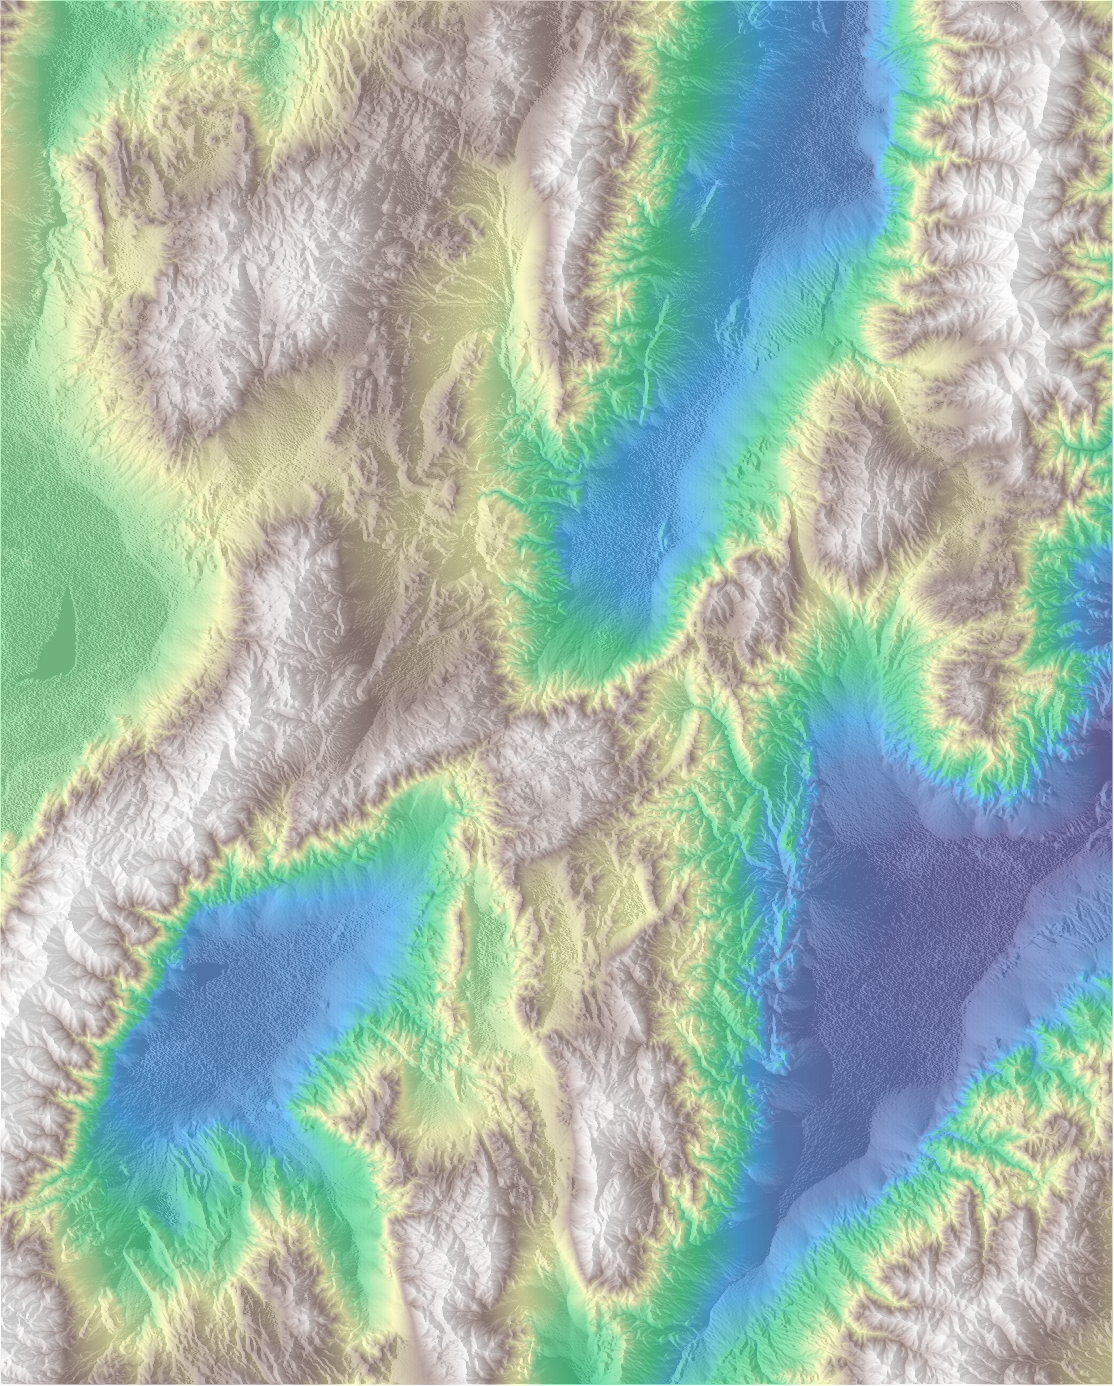

In [3]:
# Render the hillshade with a coloramp of the values applied on top
elevation_shaded = hillshade(elevation, azimuth=100, angle_altitude=50)
stack(
    shade(elevation_shaded, cmap=["white", "gray"]),
    shade(elevation, cmap=plt.get_cmap("terrain"), alpha=128)
)

#### Load temperature data

Temperature data in this example is collected for day time of 4 months of 2021 as specified in the dictionary below. 

In [4]:
datetimes = {
    'March': '2021-03-31T00:00:00.000000000',
    'June': '2021-06-30T00:00:00.000000000',
    'September': '2021-09-30T00:00:00.000000000',
    'December': '2021-12-31T00:00:00.000000000'
}

MODIS Day Land Surface Temperature data is saved in Kelvin scale. Let's convert them to Fahrenheit that we're more familiar with.

In [5]:
def kelvin_to_fahrenheit(k):
    return (k - 273.15) * 9/5 + 32 

Load day time temperature data.

In [6]:
day_temp_data = xr.open_rasterio('day_temp_data.tif')

# replace 0s with NaNs
day_temp_data = day_temp_data.where(day_temp_data > 0, np.nan)

# convert to Fahrenheit scale
day_temp_data.data = kelvin_to_fahrenheit(day_temp_data.data)

day_temp_data

/tmp/ipykernel_762/343942583.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  day_temp_data = xr.open_rasterio('day_temp_data.tif')


<xarray.DataArray (band: 4, y: 1386, x: 1114)>
array([[[ 62.834,  62.834,  62.834, ...,  97.754,  97.754,  97.754],
        [ 67.154,  67.154,  67.154, ...,  97.682,  98.258,  98.258],
        [ 67.154,  67.154,  67.154, ...,  97.682,  97.682,  98.258],
        ...,
        [ 76.226,  76.226,  76.226, ...,  85.586,  85.586,  85.586],
        [ 76.226,  76.226,  76.226, ...,  85.586,  85.586,  85.586],
        [ 76.226,  76.226,  76.226, ...,  85.586,  85.586,  85.586]],

       [[    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ..., 105.746,     nan,     nan],
        [    nan,     nan,     nan, ..., 105.746, 105.746,     nan],
        ...,
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan]],

       [[ 70.826,  70.826,  70.826, ...,  99.194,  99.194,  99.194],
        [ 73.922,  73.922,  73.922, ...,  98.33 ,  99.158,  99.158],
        [ 73.922,  73.922,  73.922, ...,  98.33 ,  98.33 ,  99.158],
        ...,
        [ 75.614,  75.614,  75.614, ...,  94.622,  94.622,  94.622],
        [ 75.614,  75.614,  75.614, ...,  94.622,  94.622,  94.622],
        [ 75.614,  75.614,  75.614, ...,  94.622,  94.622,  94.622]],

       [[ 25.178,  25.178,  25.178, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,  49.694,  49.694,  49.694],
        [    nan,     nan,     nan, ...,  49.694,  49.694,  49.694],
        ...,
        [ 29.426,  29.426,  29.426, ...,     nan,     nan,     nan],
        [ 29.426,  29.426,  29.426, ...,     nan,     nan,     nan],
        [ 29.426,  29.426,  29.426, ...,     nan,     nan,     nan]]])
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 4.439e+06 4.439e+06 4.439e+06 ... 4.301e+06 4.301e+06
  * x        (x) float64 -1.314e+07 -1.314e+07 ... -1.302e+07 -1.302e+07
Attributes:
    transform:      (100.0, 0.0, -13135700.0, 0.0, -100.0, 4439200.0)
    crs:            +init=epsg:3857
    res:            (100.0, 100.0)
    is_tiled:       0
    nodatavals:     (nan, nan, nan, nan)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    descriptions:   ('LST_Day_1km', 'LST_Day_1km', 'LST_Day_1km', 'LST_Day_1km')
    AREA_OR_POINT:  Area

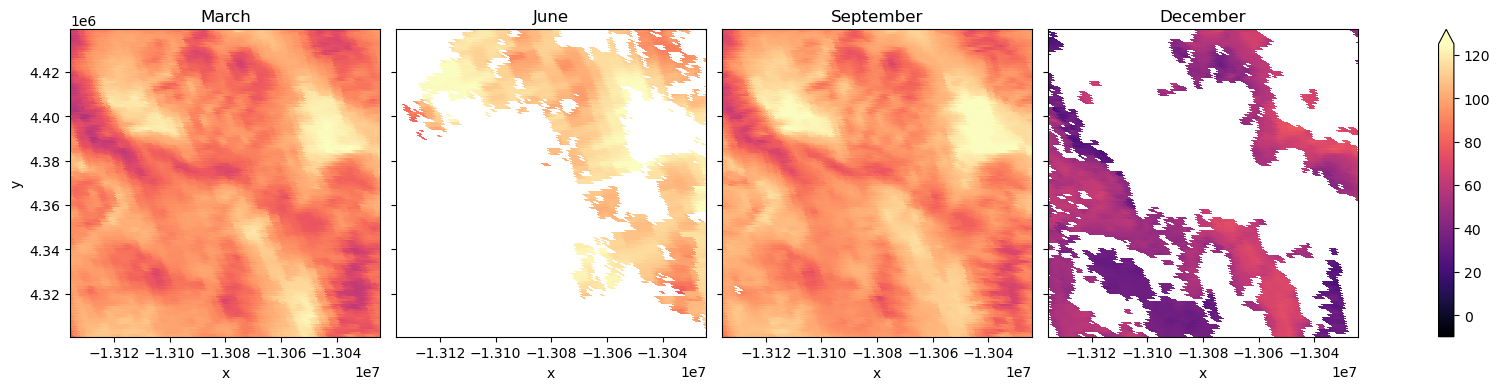

In [7]:
day_temp_plots = day_temp_data.plot.imshow(cmap="magma", vmin=-10, vmax=125, col="band", size=4)
for ax, datetime in zip(day_temp_plots.axes.flat, datetimes.keys()):
    ax.set_title(datetime)

## 2D Zonal Crosstab

2D zonal crosstab works on two different 2D datasets, one for `zones`, and the other for `values`.

To define `zones` data, we'll use `xrspatial.classify.quantile` function to group elevation data into different classes. Each class will be a separate zone.

In [8]:
n_elevation_classes = 10
zones = quantile(elevation, k=n_elevation_classes, name='Elevation Zones')

shaded_zones = shade(zones, cmap=plt.get_cmap("terrain"), how="linear")

In order to define the 2D `values` data, let's use day time temperature of March 2021 and categorize them into different classes. Each class contains temperature with similar values. We'll use `xrspatial.classify.quantile` once more to do this.

In [9]:
day_temp_march = day_temp_data[0]

n_temp_classes = 10
classified_day_temp_march = quantile(day_temp_march, k=n_temp_classes, name='Temperature Classes (March)')
shaded_temp_classes_march = shade(classified_day_temp_march, cmap=plt.get_cmap("coolwarm"), how="linear")

Visualize the `zones` and `values` we've defined above.


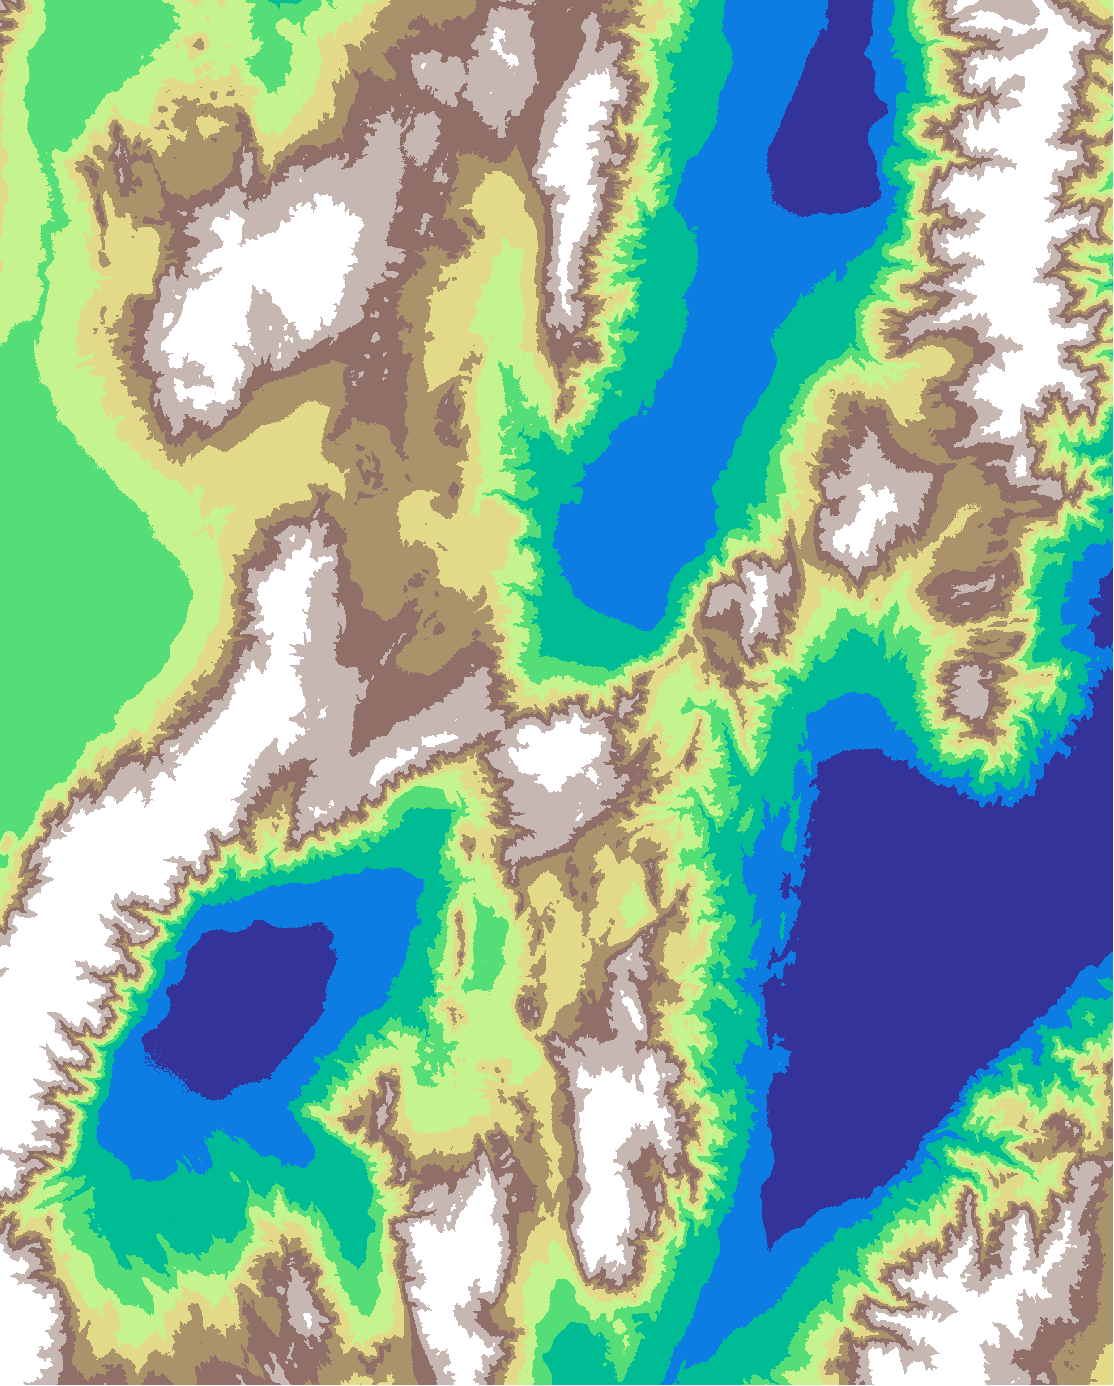
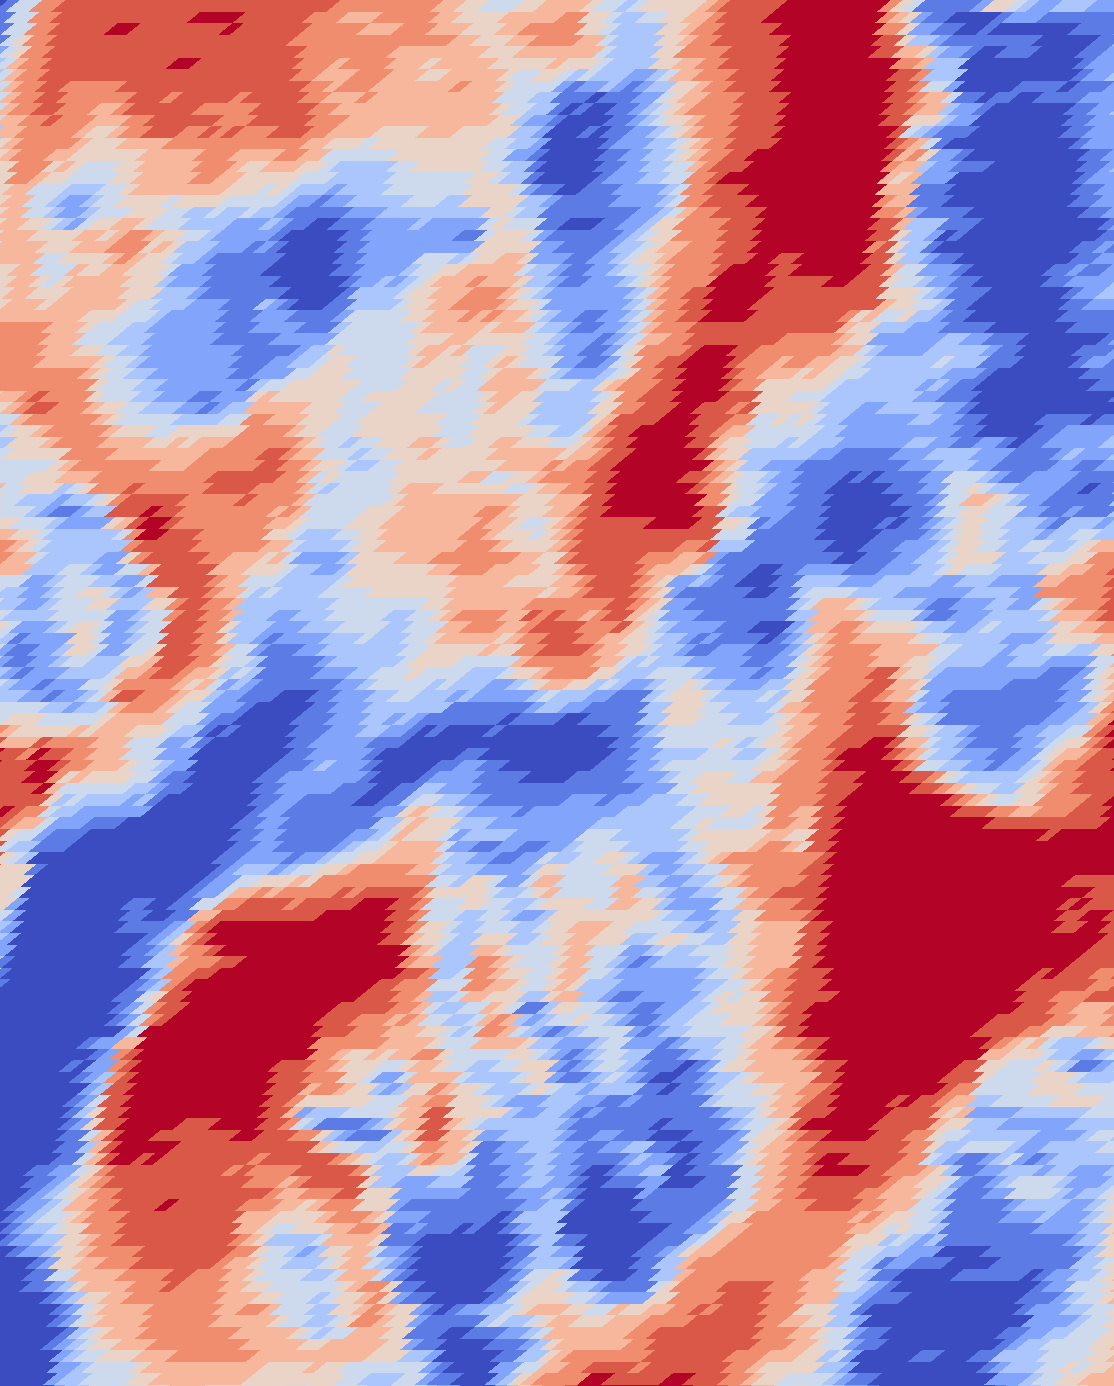

In [10]:
imgs = Images(shaded_zones, shaded_temp_classes_march)
imgs.num_cols = 2
imgs

Let's write a small util function to get range of each class/category in a categorical data array. From that, we can know exactly what range a elevation `zone` covers, and what range a temperature class is.

In [11]:
# util function to calculate range of each class/bin

def bin_ranges(classified_data, original_data, unit):
    bins = np.unique(classified_data.data[~np.isnan(classified_data.data)])
    ranges = []
    for b in bins:
        bin_data = original_data.data[classified_data.data==b]
        ranges.append(f'{np.nanmin(bin_data):.1f}{unit} - {np.nanmax(bin_data):.1f}{unit}')
    return ranges

In [12]:
elevation_ranges = bin_ranges(zones, elevation, 'm')
elevation_ranges

['-79.0m - 366.0m',
 '367.0m - 624.0m',
 '625.0m - 978.0m',
 '979.0m - 1152.0m',
 '1153.0m - 1341.0m',
 '1342.0m - 1501.0m',
 '1502.0m - 1631.0m',
 '1632.0m - 1795.0m',
 '1796.0m - 2039.0m',
 '2040.0m - 3367.0m']

In [13]:
temperature_ranges = bin_ranges(classified_day_temp_march, day_temp_march, 'F')
temperature_ranges

['54.1F - 77.8F',
 '77.8F - 83.7F',
 '83.7F - 87.3F',
 '87.4F - 90.5F',
 '90.6F - 93.5F',
 '93.5F - 96.2F',
 '96.3F - 99.2F',
 '99.2F - 102.9F',
 '102.9F - 109.2F',
 '109.2F - 125.4F']

Now we got all the data we need. Let's run zonal crosstab to see how temperature is changed by elevation for March 2021.

In [14]:
temp_march_by_elevation = zonal_crosstab(zones, classified_day_temp_march, agg='percentage')
temp_march_by_elevation['zone'] = elevation_ranges
temp_march_by_elevation.columns = ['Elevation', *temperature_ranges]
temp_march_by_elevation.set_index('Elevation', inplace=True)
temp_march_by_elevation

54.1F - 77.8F  77.8F - 83.7F  83.7F - 87.3F  87.4F - 90.5F  \
Elevation                                                                       
-79.0m - 366.0m         0.000000       0.000000       0.000000       0.097113   
367.0m - 624.0m         0.000000       0.024622       0.259829       0.771065   
625.0m - 978.0m         0.003248       1.397243       3.987762       5.753316   
979.0m - 1152.0m        0.055236       3.724234      10.175197      14.847548   
1153.0m - 1341.0m       0.370670       6.649386       9.597900      13.254058   
1342.0m - 1501.0m       1.337127      10.156472      11.927454      17.702703   
1502.0m - 1631.0m       2.484808      11.177402      14.118789      15.914494   
1632.0m - 1795.0m       6.446990      17.744393      19.470089      17.099436   
1796.0m - 2039.0m      21.432337      29.889044      22.060326      11.556308   
2040.0m - 3367.0m      68.785635      19.118823       8.514664       2.766924   

                   90.6F - 93.5F  93.5F - 96.2F  96.3F - 99.2F  \
Elevation                                                        
-79.0m - 366.0m         0.304288       1.229452       3.947326   
367.0m - 624.0m         2.887282       4.067854       7.597906   
625.0m - 978.0m        11.581334      16.859808      17.977083   
979.0m - 1152.0m       16.130332      15.331678      11.412493   
1153.0m - 1341.0m      13.109549      15.421054      17.987882   
1342.0m - 1501.0m      12.818440      14.869391      15.428682   
1502.0m - 1631.0m      18.898869      18.104903      11.039321   
1632.0m - 1795.0m      18.056865       9.313466       9.414826   
1796.0m - 2039.0m       6.406143       4.554062       3.939739   
2040.0m - 3367.0m       0.518148       0.256799       0.039007   

                   99.2F - 102.9F  102.9F - 109.2F  109.2F - 125.4F  
Elevation                                                            
-79.0m - 366.0m          7.089260        18.367334        68.965227  
367.0m - 624.0m         21.674053        35.018661        27.698727  
625.0m - 978.0m         23.895392        17.630858         0.913957  
979.0m - 1152.0m        13.106626        14.276338         0.940319  
1153.0m - 1341.0m       13.136766         9.659463         0.813272  
1342.0m - 1501.0m       11.469675         4.272598         0.017458  
1502.0m - 1631.0m        7.479174         0.782242         0.000000  
1632.0m - 1795.0m        2.425530         0.028407         0.000000  
1796.0m - 2039.0m        0.162041         0.000000         0.000000  
2040.0m - 3367.0m        0.000000         0.000000         0.000000

In the result table, each cell represents the percentage of a temperature class that falls within an elevation zone. It can easily be seen that the temperature decreases when the elevation increases and vice versa, the temperature increases when the elevation decreases.

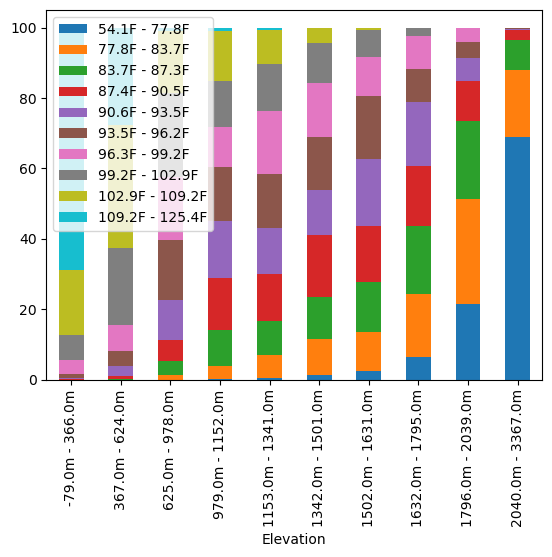

In [15]:
temp_march_by_elevation.plot(kind="bar", stacked=True);

## 3D Zonal Crosstab

3D zonal crosstab works on a 2D `zones` data array with a 3D `values` data array. There are many aggregation methods for calculating the cross tabulated stats between the 2 datasets: `[min, max, mean, sum, std, var, count]`.

In this example, let's see how the average temperature are changed by elevation over time for day time temperature.

In [18]:
mean_day_temp = zonal_crosstab(zones, day_temp_data, agg='mean')
mean_day_temp['zone'] = elevation_ranges
mean_day_temp.columns = ['Elevation', *datetimes.keys()]
mean_day_temp.set_index('Elevation', inplace=True)

mean_day_temp

March        June   September   December
Elevation                                                      
-79.0m - 366.0m    94.837037  112.810320   99.941600  54.275154
367.0m - 624.0m    92.745852  111.027988   97.037565  51.465730
625.0m - 978.0m    96.302777  113.616043  100.432735  54.524392
979.0m - 1152.0m   92.588081  110.469486   96.814603  49.643059
1153.0m - 1341.0m  92.261270  110.363763   96.513447  49.137776
1342.0m - 1501.0m  92.778845  110.391099   96.888314  50.656112
1502.0m - 1631.0m  93.343100  110.468353   97.293143  51.623289
1632.0m - 1795.0m  92.411455  109.740883   96.445604  50.115511
1796.0m - 2039.0m  92.603392  109.674150   96.794117  50.194057
2040.0m - 3367.0m  94.374847  111.213077   98.549799  51.912018

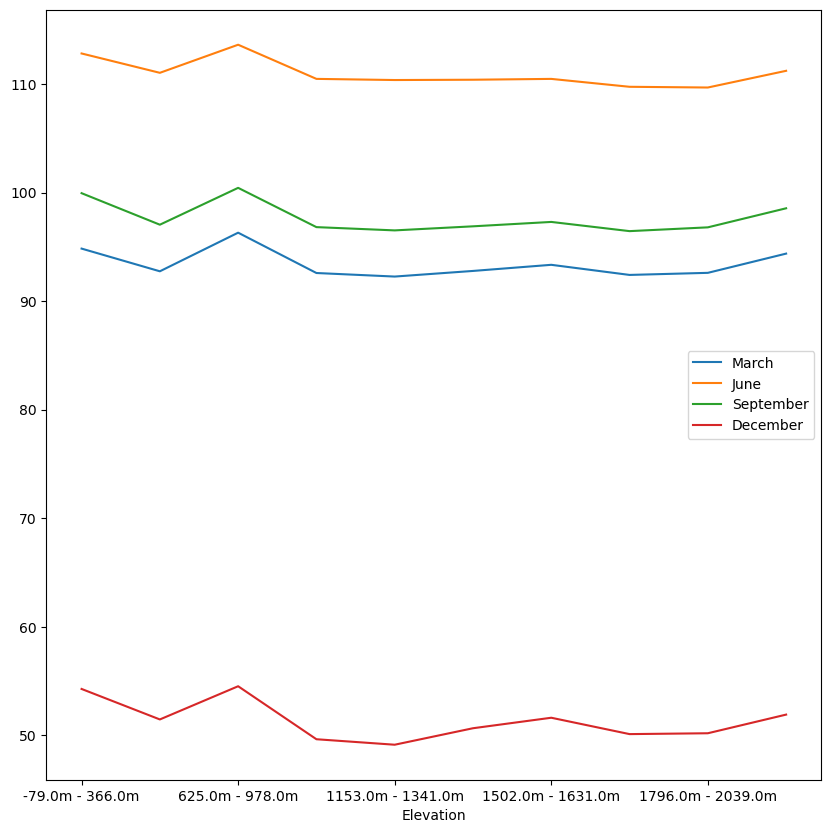

In [19]:
mean_day_temp.reset_index().plot(
    x="Elevation", y=datetimes.keys(), kind="line", figsize=(10, 10)
);

Looking at the result of mean temperature for day time over the year, we can see that temperature reaches highest in June, and lowest in December. And it tends to decrease with increase in elevation height.